In [1]:
import pandas as pd
import seaborn as sns
from random import shuffle
import time
from sklearn.neighbors import LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree, metrics, preprocessing
from sklearn.model_selection import cross_val_predict, cross_val_score
import graphviz, pydot
import itertools
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,accuracy_score, roc_auc_score, roc_curve, auc
from IPython.display import display, HTML
import warnings
from scipy import interp
from scipy.stats import pearsonr
from datetime import timedelta

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    
cv=8
class_names = ['not fraud', 'fraud']
dt = DecisionTreeClassifier()
    
    
display(HTML(data="""
<style>
    div#notebook-container    { width: 99%; }
    div#menubar-container     { width: 99%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

In [2]:
class PDF(object):
  def __init__(self, pdf, size=(200,200)):
    self.pdf = pdf
    self.size = size

  def _repr_html_(self):
    return '<iframe src={0}  onload="this.width=screen.width;this.height=screen.height/3;"></iframe>'.format(self.pdf, self.size)

  def _repr_latex_(self):
    return r'\includegraphics[width=1.0\textwidth]{{{0}}}'.format(self.pdf)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
     
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    '''    
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    '''
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_cm(y,y_pred, class_names):
    print('Confusion Matrix')
    cnf_matrix = metrics.confusion_matrix(y, y_pred)
    
    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Without normalization')
    
    # Plot normalized confusion matrix
    # plt.figure()
    # plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
    #                      title='Normalized')

    plt.show()
    
def export_tree(dt, filename):
    dot_data = tree.export_graphviz(dt, out_file=None,
                         feature_names=df2.columns.values,  
                         class_names=class_names,  
                         filled=True, rounded=True,  
                         special_characters=True)
    graph = graphviz.Source(dot_data) 
    output = graph.render(filename) 
    print("results saved: ", output)
    return output
    # (graph,) = pydot.graph_from_dot_file(filename)
    # graph.write_png(filename+'.png')
    


def plot_score_3d(results):
    fig = plt.figure(figsize=(13, 13))
    
    ax = fig.add_subplot(111, projection='3d')

    # For each set of style and range settings, plot n random points in the box
    # defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
    max_depth = np.array(results['param_max_depth'].data, dtype=float)
    min_samples_leaf = np.array(results['param_min_samples_leaf'].data, dtype=float)
    score = results['mean_test_Accuracy']
    ax.scatter(max_depth, min_samples_leaf, score)

    ax.set_xlabel('max_depth')
    ax.set_ylabel('min_samples_leaf')
    ax.set_zlabel('Score')

    plt.show()


def plot_score(results):
    plt.figure(figsize=(13, 13))
    plt.title("GridSearchCV evaluating using multiple scorers simultaneously",
              fontsize=16)

    plt.xlabel("max depth")
    plt.ylabel("Score")
    plt.grid()

    ax = plt.axes()
    #ax.set_xlim(0, 402)
    ax.set_ylim(0.85, 1)

    # Get the regular numpy array from the MaskedArray
    X_axis = np.array(results['param_max_depth'].data, dtype=float)

    for scorer, color in zip(sorted(scoring), ['g', 'k']):
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
            sample_score_std = results['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                            sample_score_mean + sample_score_std,
                            alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color,
                    alpha=1 if sample == 'test' else 0.7,
                    label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = results['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
                linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score,
                    (X_axis[best_index], best_score + 0.005))

    plt.legend(loc="best")
    plt.grid('off')
    plt.show()
    
def report(y,y_pred,class_names):
    plot_cm(y,y_pred,class_names)
    print(metrics.classification_report(y, y_pred))
    print('ROC_AUC score', roc_auc_score(y,y_pred))
    
def reset_data():
    global cv
    cv=8
    global class_names 
    class_names = ['not fraud', 'fraud']
    global dt
    dt = DecisionTreeClassifier()
    
    df = pd.read_csv('bs140513_032310.csv')
    df.age=df.age.map(lambda x: x.lstrip("'").rstrip("'"))
    df.merchant=df.merchant.map(lambda x: x.lstrip("'").rstrip("'"))
    df.customer=df.customer.map(lambda x: x.lstrip("'").rstrip("'"))
    df.category=df.category.map(lambda x: x.lstrip("'").rstrip("'"))
    
    df['age']= df['age'].str.replace('U','-1')
    df.age = pd.to_numeric(df.age)
    
    df = df.drop(['zipcodeOri', 'zipMerchant'], axis=1)
    
    df.loc[df.gender == "'M'", 'gender'] = 0
    df.loc[df.gender == "'F'", 'gender'] = 1
    df.loc[df.gender == "'E'", 'gender'] = -1
    df.loc[df.gender == "'U'", 'gender'] = -1
    df.gender = pd.to_numeric(df.gender) # ensure there are no str left
    
    df.merchant=df.merchant.map(lambda x: x.lstrip("M"))
    df.customer=df.customer.map(lambda x: x.lstrip("C"))

    df.customer = pd.to_numeric(df.customer)
    df.merchant = pd.to_numeric(df.merchant)
    return df

In [3]:
df = reset_data()

<table align=left> 
    <tr><th>Age (converted to)</th><th>Gender (converted to)</th><th>Categories</th></tr>
    <tr><td>0 - <=18 (0)</td><td>M - Male (0)</td><td>es_barsandrestaurants</td></tr>
    <tr><td>1 - 19-25 (1)</td><td>F - Female (1)</td><td>es_contents</td></tr>
    <tr><td>2 - 26-35 (2)</td><td>E - Enterprise (-1)</td><td>es_fashion</td></tr>
    <tr><td>3 - 36-45 (3)</td><td>U Unknown (-1)</td><td>es_food</td></tr>
    <tr><td>4 - 46-55 (4)</td><td></td><td>es_health</td></tr>
    <tr><td>5 - 56-65 (5)</td><td></td><td>es_home</td></tr>
    <tr><td>6 - >65 (6)</td><td></td><td>es_hotelservices</td></tr>
    <tr><td>U Unknown (-1)</td><td></td><td>es_hyper</td></tr>
    <tr><td></td><td></td><td>es_leisure</td></tr>
    <tr><td></td><td></td><td>es_otherservices</td></tr>
    <tr><td></td><td></td><td>es_sportsandtoys</td></tr>
    <tr><td></td><td></td><td>es_tech</td></tr>
    <tr><td></td><td></td><td>es_transportation</td></tr>
    <tr><td></td><td></td><td>es_travel</td></tr>
    <tr><td></td><td></td><td>es_wellnessandbeauty</td></tr>
</table>

In [4]:
df.head()

,step,customer,age,gender,merchant,category,amount,fraud
0,0,1093826151,4,0,348934600,es_transportation,4.55,0
1,0,352968107,2,0,348934600,es_transportation,39.68,0
2,0,2054744914,4,1,1823072687,es_transportation,26.89,0
3,0,1760612790,3,0,348934600,es_transportation,17.25,0
4,0,757503768,5,0,348934600,es_transportation,35.72,0


# Run model without parameter tunning

In [5]:
df2 = df
y = df2["fraud"]
df2 = df2.drop(["fraud", 'customer', 'step'], axis=1)
df2=pd.get_dummies(df2, columns=["category"])

X = df2

### Train Model with 10 cross validations and default parameters, in all cores

In [6]:
dt.fit(X, y)
y_pred_default = cross_val_predict(dt, X, y, cv=cv, n_jobs=-1)

In [7]:
dt

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Classification Report

In [8]:
print(metrics.classification_report(y, y_pred_default))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00    587443
          1       0.74      0.75      0.74      7200

avg / total       0.99      0.99      0.99    594643



### Confusion Matrix

Confusion Matrix


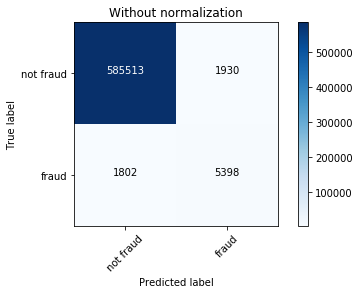

In [9]:
plot_cm(y,y_pred_default,class_names)

### Export tree graph in pdf

In [10]:
out = export_tree(dt,'dt_default')

results saved:  dt_default.pdf


In [11]:
PDF(out)

# Run model with parameter tunning (grid search)

In [12]:
params = {
        'class_weight':[None],
        'criterion':['entropy'],
        'max_depth':range(2,40, 4),
        #'max_depth':range(13,16, 1),
        'min_samples_leaf':range(12, 14, 4),
        'max_features':[None],
        'max_leaf_nodes':[None],
        'min_impurity_decrease':[0.0],
        'min_impurity_split':[None],
        'min_samples_split':[2],
        'min_weight_fraction_leaf':[0.0],
        'presort':[False],
        'random_state':[87],
        'splitter':['best']
}

scoring = {'AUC': make_scorer(roc_auc_score), 'Accuracy': make_scorer(accuracy_score)}
gs = GridSearchCV(dt,n_jobs=-1, 
                  param_grid=params, 
                  scoring=scoring, 
                  return_train_score=True, 
                  cv=cv, 
                  refit='Accuracy',verbose=1)

start_time = time.time()
gs.fit(X, y)
elapsed_time = time.time() - start_time
print("ellapsed time", elapsed_time)
#gs.cv_results_

Fitting 8 folds for each of 10 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   24.7s finished


ellapsed time 25.81745171546936


In [13]:
print("Best parameters set found on development set:")
print()
print(gs.best_params_)
#print("Grid scores on development set:")
#print()
#means = gs.cv_results_['mean_test_AUC']
#stds = gs.cv_results_['std_test_AUC']
#for mean, std, params in zip(means, stds, gs.cv_results_['params']):
#    print("%0.3f (+/-%0.03f) for %r"
#          % (mean, std * 2, params))
#print()


Best parameters set found on development set:

{'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 12, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 87, 'splitter': 'best'}


/Users/canf/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


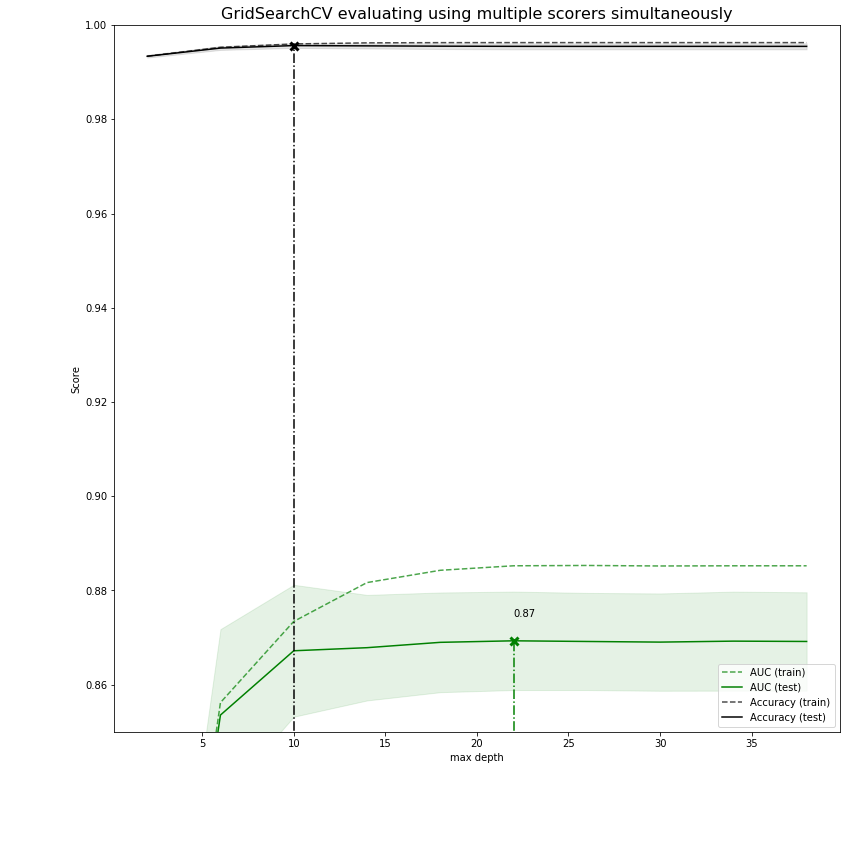

In [14]:
plot_score(gs.cv_results_)

In [15]:
print("AUC score: \t",gs.cv_results_['mean_test_AUC'].mean())
print("Accuracy score:\t",gs.cv_results_['mean_test_Accuracy'].mean())

AUC score: 	 0.8551893257593643
Accuracy score:	 0.9952769981316522


In [16]:
dt = gs.best_estimator_

### Train Model with optimal parameters,10 cross validations and default parameters, in all cores

In [17]:
y_pred_param_tune = cross_val_predict(dt, X, y, cv=cv, n_jobs=-1)

### Classification Report

Confusion Matrix


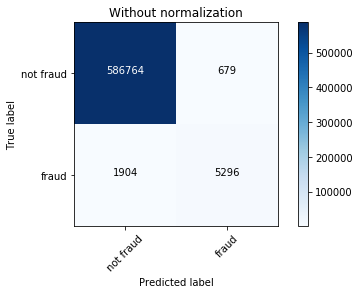

             precision    recall  f1-score   support

          0       1.00      1.00      1.00    587443
          1       0.89      0.74      0.80      7200

avg / total       1.00      1.00      1.00    594643

ROC_AUC score 0.8671998493659999


In [18]:
report(y,y_pred_param_tune,class_names)

### Export tree graph in pdf

In [19]:
out = export_tree(dt,'dt_param_tune')

results saved:  dt_param_tune.pdf


In [20]:
PDF(out)

# Feature Engineering : create additional features

In [3]:
df = reset_data()

In [4]:
df['cust_tl_count_trans'] = df['amount'].groupby(df['customer']).transform('count')
#df['cust_cat_count_trans'] = df.groupby(['customer', 'category'])['amount'].transform('count')
#df['cust_mer_count_trans'] = df.groupby(['customer', 'merchant'])['amount'].transform('count')

df['cust_tl_mean_amount'] = df['amount'].groupby(df['customer']).transform('mean')
df['cat_mean_amount'] = df.groupby(['category'])['amount'].transform('mean')
df['cust_mer_mean_amount'] = df.groupby(['merchant'])['amount'].transform('mean')
#df['cust_cat_mean_amount'] = df.groupby(['customer', 'category'])['amount'].transform('mean')
#df['cust_mer_mean_amount'] = df.groupby(['customer', 'merchant'])['amount'].transform('mean')

df['cust_tl_median_amount'] = df['amount'].groupby(df['customer']).transform('median')
#df['cust_cat_median_amount'] = df.groupby(['customer', 'category'])['amount'].transform('median')
#df['cust_mer_median_amount'] = df.groupby(['customer', 'category'])['amount'].transform('median')

df['cust_tl_std_amount'] = df['amount'].groupby(df['customer']).transform('std')
df['cat_mean_amount'] = df.groupby(['category'])['amount'].transform('std')
df['cust_mer_mean_amount'] = df.groupby(['merchant'])['amount'].transform('std')
#df['cust_cat_std_amount'] = df.groupby(['customer', 'category'])['amount'].transform('std')
#df['cust_mer_std_amount'] = df.groupby(['customer', 'merchant'])['amount'].transform('std')

df['cust_tl_max_amount'] = df['amount'].groupby(df['customer']).transform('max')
df['cat_mean_amount'] = df.groupby(['category'])['amount'].transform('max')
df['cust_mer_mean_amount'] = df.groupby(['merchant'])['amount'].transform('max')
#df['cust_cat_max_amount'] = df.groupby(['customer', 'category'])['amount'].transform('max')
#df['cust_mer_max_amount'] = df.groupby(['customer', 'merchant'])['amount'].transform('max')

df['cust_tl_min_amount'] = df['amount'].groupby(df['customer']).transform('min')
df['cat_mean_amount'] = df.groupby(['category'])['amount'].transform('min')
df['cust_mer_mean_amount'] = df.groupby(['merchant'])['amount'].transform('min')
#df['cust_cat_min_amount'] = df.groupby(['customer', 'category'])['amount'].transform('min')
#df['cust_mer_min_amount'] = df.groupby(['customer', 'merchant'])['amount'].transform('min')

df = df.fillna(0)


(-1, 1500)

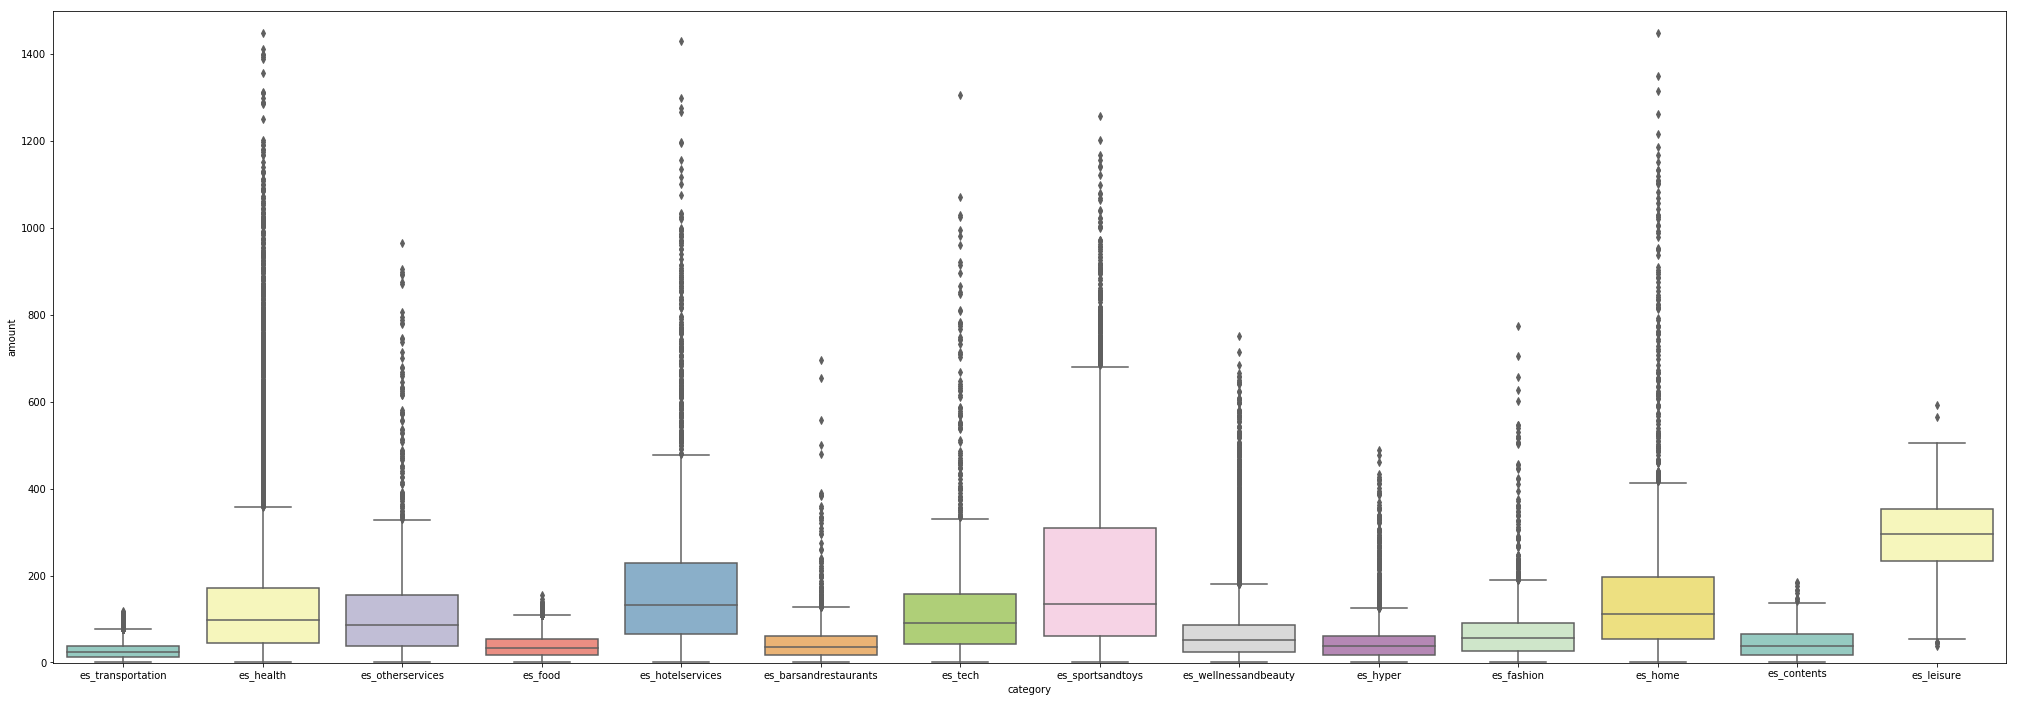

In [5]:
fig, ax = plt.subplots()
fig.set_size_inches(35, 12)
ax = sns.boxplot(x="category", y="amount", data=df[df['category']!='es_travel'], palette="Set3")
ax.set_ylim(-1,1500)

In [6]:
category_sample = list(set(list(df['category'])))
customer_sample = list(set(list(df['customer'])))

(-1, 400)

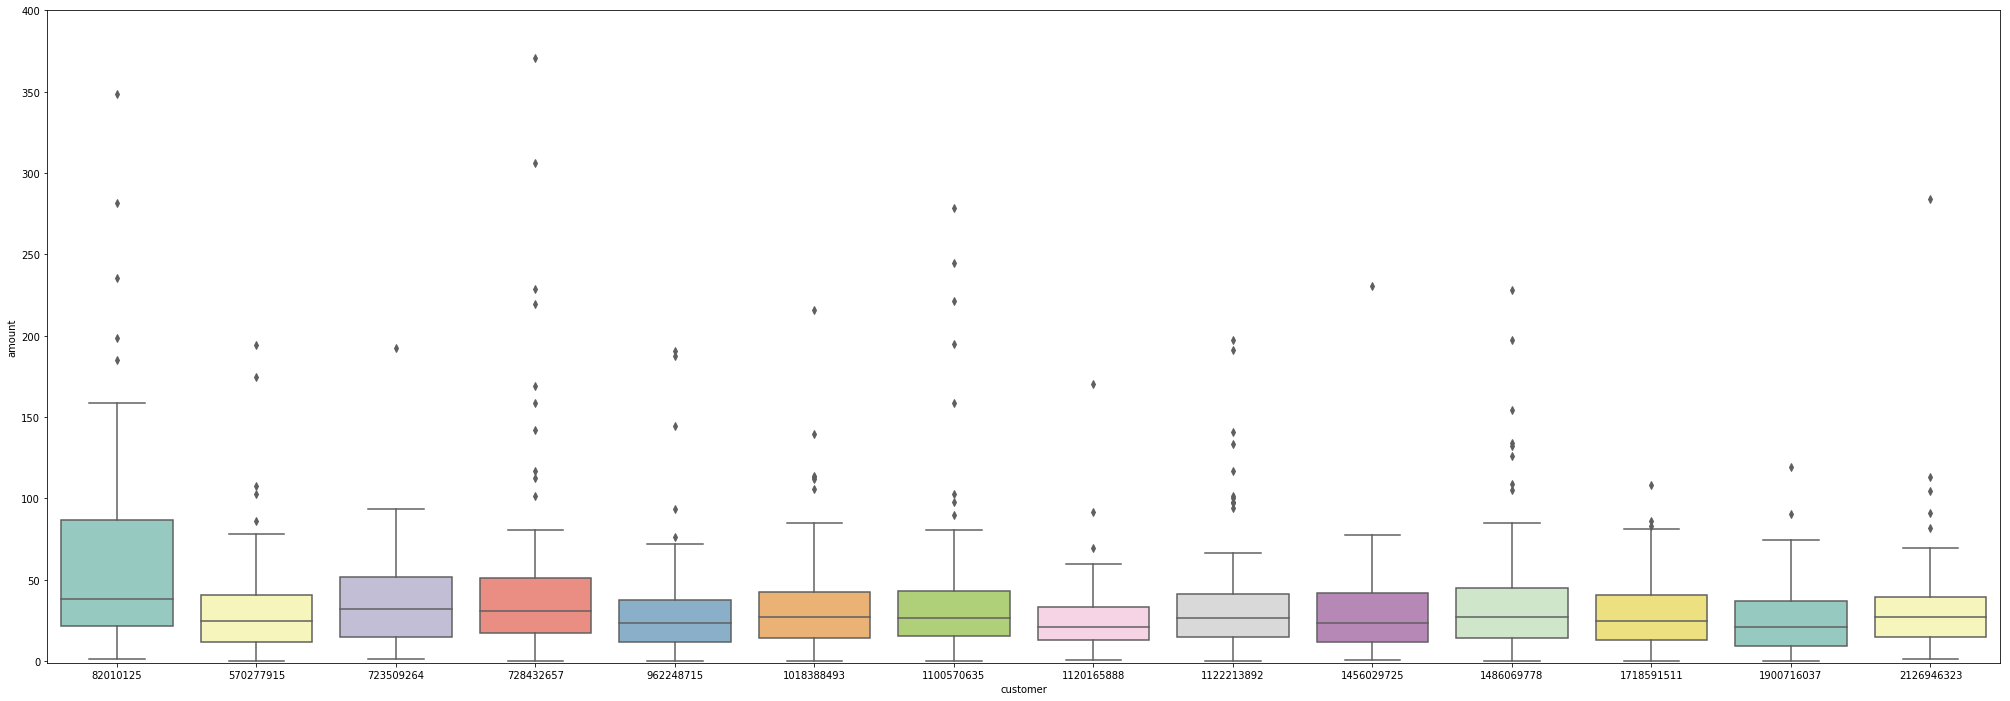

In [7]:
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(35, 12)
ax = sns.boxplot(x="customer", y="amount", data=df[df['customer'].isin(customer_sample[:14])], palette="Set3")
ax.set_ylim(-1,400)

In [8]:

clf = LocalOutlierFactor()
def outlier_detect(amount, neigh):
    if (len(amount)>neigh):
        clf.n_neighbors = neigh
    elif (len(amount)==1):
        return [1]
    else:
        clf.n_neighbors = len(amount)-1

    yy = clf.fit_predict(np.array(amount).reshape(-1, 1))
    return yy
    
''' 
df['ol_cust_cat_amount'] = df.groupby(['customer','category'])['amount'].transform(outlier_detect,30)
df['ol_cust_mer_amount'] = df.groupby(['customer','merchant'])['amount'].transform(outlier_detect,30)
df['ol_cust_tl_amount'] = df.groupby(['customer'])['amount'].transform(outlier_detect,30)
df['ol_cat_amount'] = df.groupby(['category'])['amount'].transform(outlier_detect,30)
df['ol_mer_amount'] = df.groupby(['merchant'])['amount'].transform(outlier_detect,30)
'''

def outlier_detect_boxplot(amount):
    median = np.median(amount)
    std = np.std(amount)
    upper_quartile = np.percentile(amount, 77) #75
    lower_quartile = np.percentile(amount, 23) #25

    iqr = upper_quartile - lower_quartile
    upper_whisker = amount[amount<=upper_quartile+1.5*iqr].max()
    lower_whisker = amount[amount>=lower_quartile-1.5*iqr].min()
    return [0 if (x<upper_whisker and x>lower_whisker) else 1 for x in amount]
   

df['ol_cust_cat_amount'] = df.groupby(['customer','category'])['amount'].transform(outlier_detect_boxplot)
df['ol_cust_mer_amount'] = df.groupby(['customer','merchant'])['amount'].transform(outlier_detect_boxplot)
df['ol_cust_tl_amount'] = df.groupby(['customer'])['amount'].transform(outlier_detect_boxplot)
df['ol_cat_amount'] = df.groupby(['category'])['amount'].transform(outlier_detect_boxplot)
df['ol_mer_amount'] = df.groupby(['merchant'])['amount'].transform(outlier_detect_boxplot)

In [9]:
df[['fraud','ol_cust_cat_amount','ol_cust_mer_amount','ol_cust_tl_amount','ol_cat_amount','ol_mer_amount']].corr()
#df.corr()

,fraud,ol_cust_cat_amount,ol_cust_mer_amount,ol_cust_tl_amount,ol_cat_amount,ol_mer_amount
fraud,1.000000,0.207759,0.205197,0.280917,0.384789,0.239819
ol_cust_cat_amount,0.207759,1.000000,0.832985,0.514114,0.209466,0.202333
ol_cust_mer_amount,0.205197,0.832985,1.000000,0.516911,0.181947,0.177404
ol_cust_tl_amount,0.280917,0.514114,0.516911,1.000000,0.258235,0.236491
ol_cat_amount,0.384789,0.209466,0.181947,0.258235,1.000000,0.814927
ol_mer_amount,0.239819,0.202333,0.177404,0.236491,0.814927,1.000000


Fraud in existing data per category


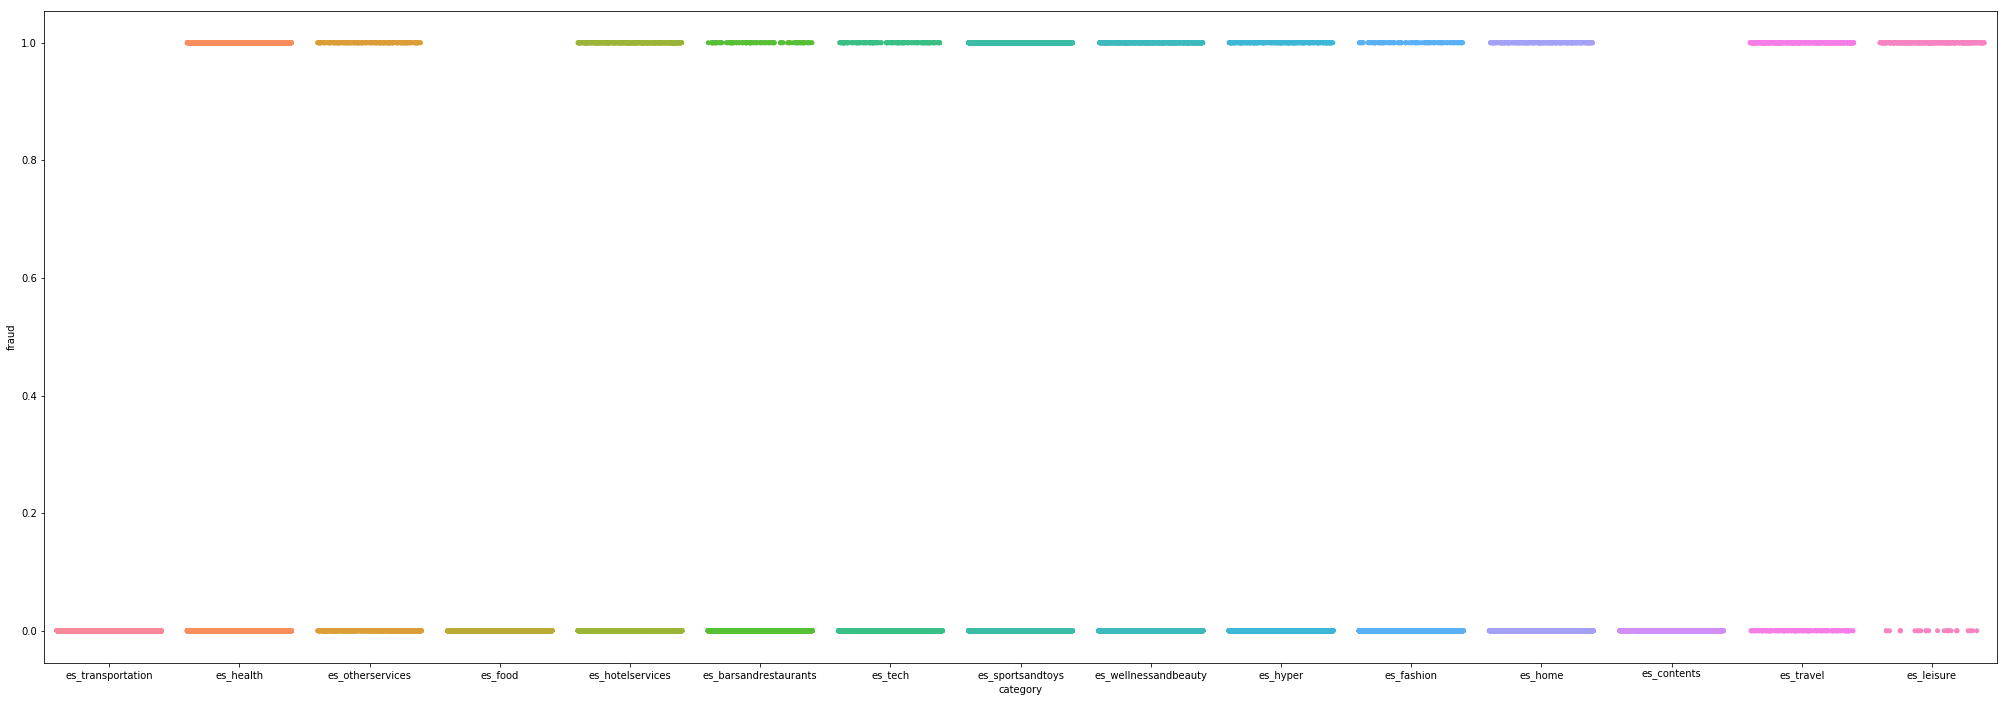

In [10]:
print('Fraud in existing data per category')

fig, ax = plt.subplots()
fig.set_size_inches(35, 12)
#ax.set_yticks([-1,0,1,2])
ax = sns.stripplot('category', 'fraud', data=df, jitter=0.4)


Outliers based on category spending amount overall (per category)


(-1, 1410)

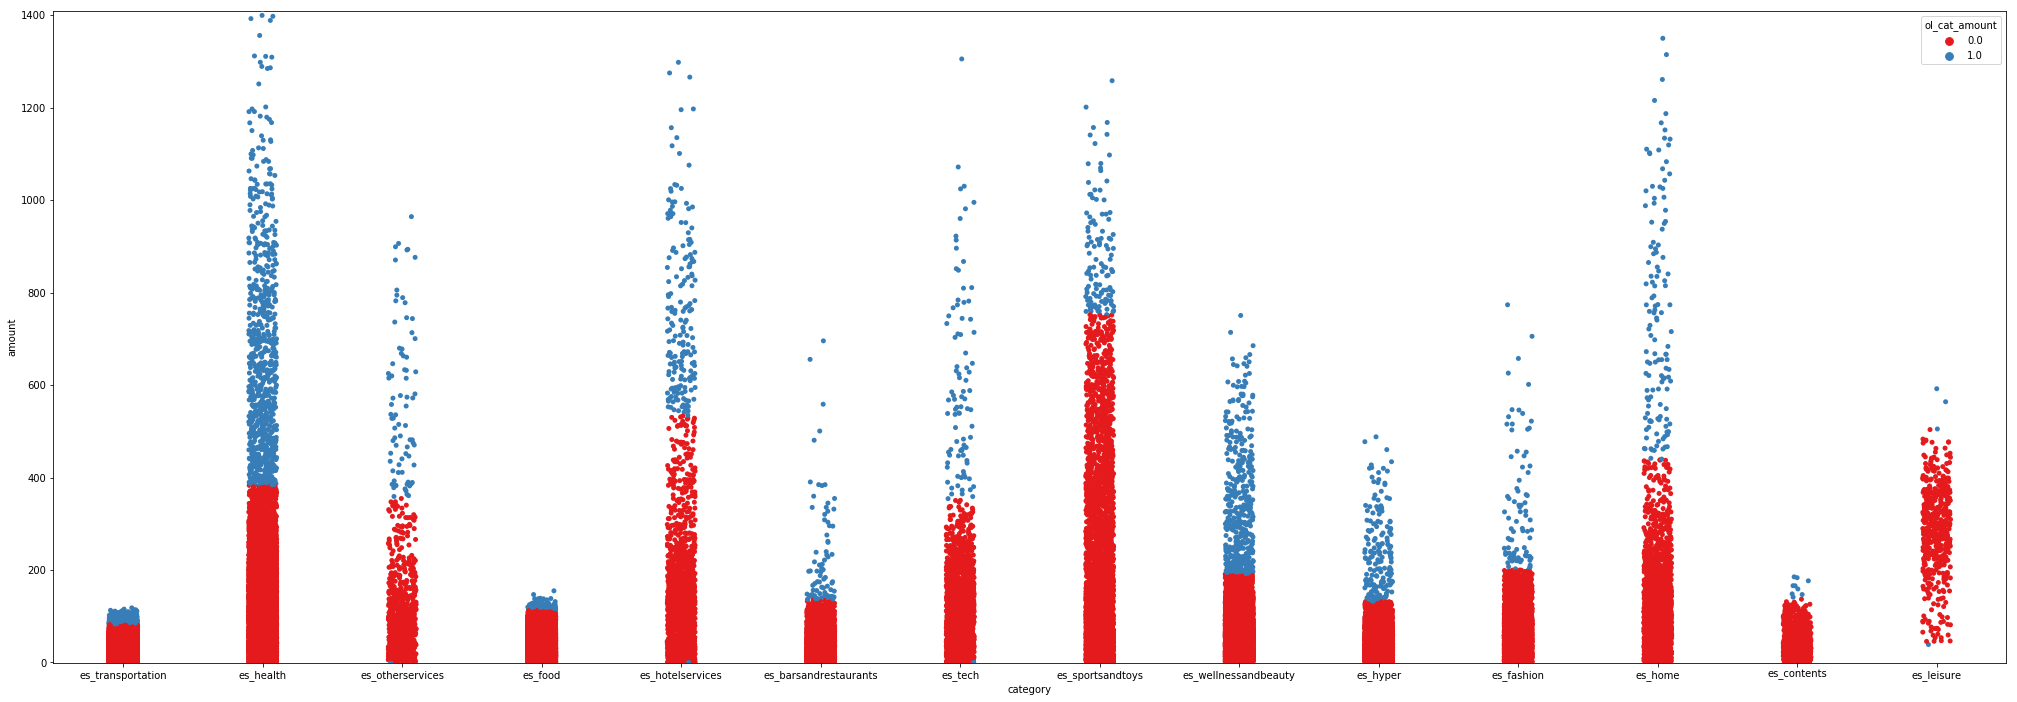

In [11]:
print('Outliers based on category spending amount overall (per category)')
fig, ax = plt.subplots()
fig.set_size_inches(35, 12)
ax = sns.stripplot(x="category", y="amount", data=df[df['category']!='es_travel'], hue="ol_cat_amount", jitter=True, palette="Set1");
ax.set_ylim(-1,1410)

Outliers based on customer spending amount overall (per customer)


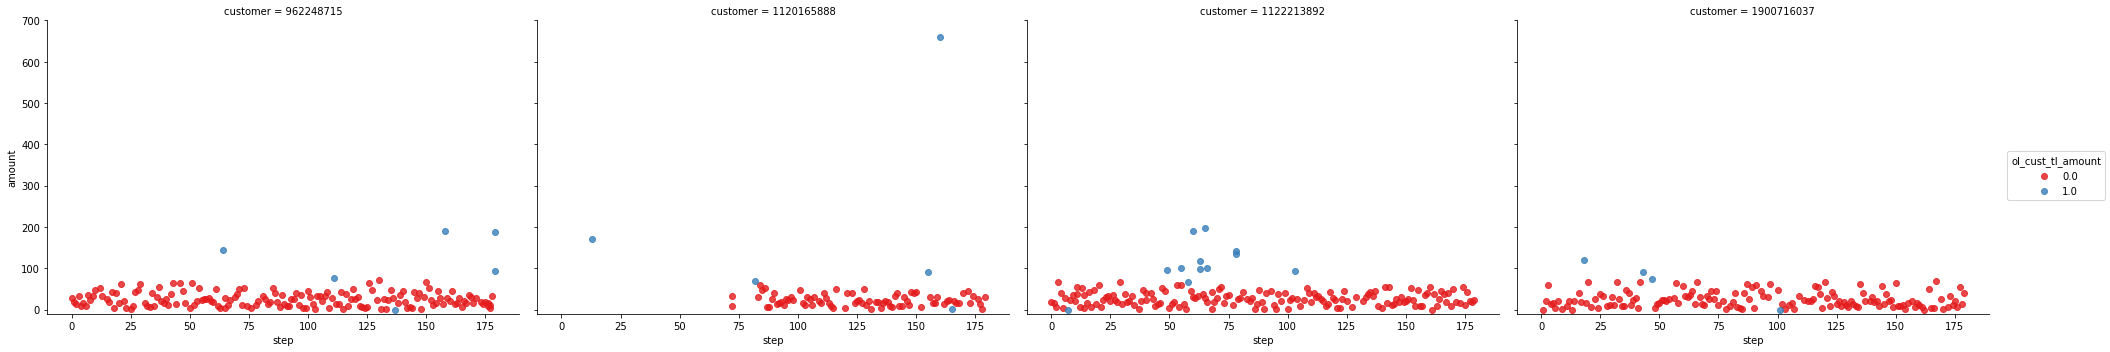

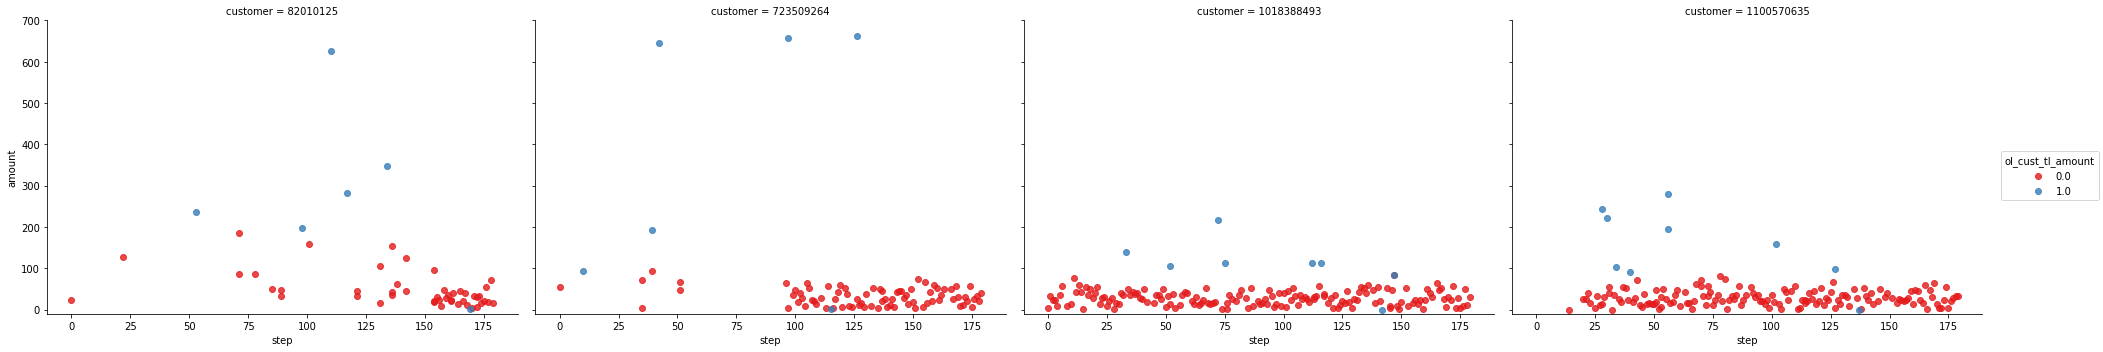

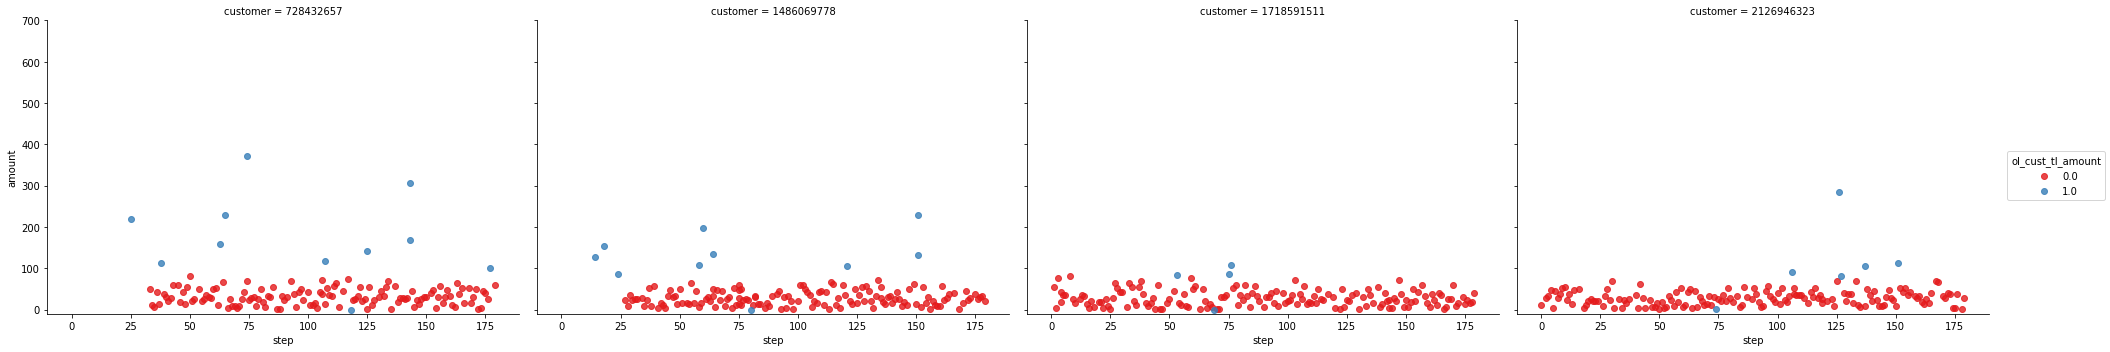

In [12]:
ip1= sns.lmplot(x="step", y="amount", hue="ol_cust_tl_amount", col="customer", data=df[df['customer'].isin(customer_sample[:4])], aspect=1.4, x_jitter=0, fit_reg=False, palette="Set1")
ip2= sns.lmplot(x="step", y="amount", hue="ol_cust_tl_amount", col="customer", data=df[df['customer'].isin(customer_sample[4:8])], aspect=1.4, x_jitter=0, fit_reg=False, palette="Set1")
ip3= sns.lmplot(x="step", y="amount", hue="ol_cust_tl_amount", col="customer", data=df[df['customer'].isin(customer_sample[8:12])], aspect=1.4, x_jitter=0, fit_reg=False, palette="Set1")

axes = ip1.axes
axes[0,0].set_ylim(-10,700)
axes = ip2.axes
axes[0,0].set_ylim(-10,700)
axes = ip3.axes
axes[0,0].set_ylim(-10,700)
print('Outliers based on customer spending amount overall (per customer)')

In [13]:
df2 = df
#df2=df.sample(frac=1)
y = df2["fraud"]
''' 
# keep original values before standartization
keep_orig_columns = ['ol_cust_cat_amount','ol_cust_mer_amount','ol_cust_tl_amount','ol_cat_amount','ol_mer_amount']
keep_as_is_df = df2[keep_orig_columns]

cat_df=pd.get_dummies(df2["category"], columns=["category"])

df2 = df2.drop(["fraud", 'customer', 'step', 'gender', 'category'], axis=1)
df2 = df2.drop(keep_orig_columns, axis=1)

scaled_features = preprocessing.StandardScaler().fit_transform(df2.values)
df2 = pd.DataFrame(scaled_features, index=df2.index, columns=df2.columns)

X = pd.concat([df2,cat_df,keep_as_is_df], axis=1)
'''


cat_df=pd.get_dummies(df2["category"], columns=["category"])
df2 = df2.drop(["fraud", 'customer', 'step', 'gender', 'category'], axis=1)
scaled_features = preprocessing.StandardScaler().fit_transform(df2.values)
df2 = pd.DataFrame(scaled_features, index=df2.index, columns=df2.columns)

df2 = pd.concat([df2,cat_df], axis=1)

X=df2
X.head()

,age,merchant,amount,cust_tl_count_trans,cust_tl_mean_amount,cat_mean_amount,cust_mer_mean_amount,cust_tl_median_amount,cust_tl_std_amount,cust_tl_max_amount,...,es_home,es_hotelservices,es_hyper,es_leisure,es_otherservices,es_sportsandtoys,es_tech,es_transportation,es_travel,es_wellnessandbeauty
0,0.749797,-1.077662,-0.299276,0.340420,-0.321238,-0.032558,-0.041391,-0.077957,-0.401789,-0.434825,...,0,0,0,0,0,0,0,1,0,0
1,-0.747257,-1.077662,0.016067,0.410385,-0.174071,-0.032558,-0.041391,0.094592,-0.346166,-0.389502,...,0,0,0,0,0,0,0,1,0,0
2,0.749797,0.912437,-0.098742,-3.227803,0.118301,-0.032558,-0.041391,0.320964,-0.213954,-0.328547,...,0,0,0,0,0,0,0,1,0,0
3,0.001270,-1.077662,-0.185275,0.480350,-0.251392,-0.032558,-0.041391,-0.077957,-0.325634,-0.359302,...,0,0,0,0,0,0,0,1,0,0
4,1.498324,-1.077662,-0.019480,-0.429197,-0.206183,-0.032558,-0.041391,0.001985,-0.342320,-0.352529,...,0,0,0,0,0,0,0,1,0,0


In [14]:
X.shape

(594643, 31)

In [15]:
params = {
        'class_weight':[None],
        'criterion':['entropy'],
        'max_depth':range(2,40, 4),
        #'max_depth':range(13,16, 1),
        'min_samples_leaf':range(12,14, 4),
        'max_features':[None],
        'max_leaf_nodes':[None],
        'min_impurity_decrease':[0.0],
        'min_impurity_split':[None],
        'min_samples_split':[2],
        'min_weight_fraction_leaf':[0.0],
        'presort':[False],
        'random_state':[87],
        'splitter':['best']
}

scoring = {'AUC': make_scorer(roc_auc_score), 'Accuracy': make_scorer(accuracy_score)}
gs = GridSearchCV(dt,n_jobs=-1, 
                  param_grid=params, 
                  scoring=scoring, 
                  return_train_score=True, 
                  cv=cv, 
                  refit='Accuracy',verbose=1)

start_time = time.time()
gs.fit(X, y)
elapsed_time = time.time() - start_time
print("ellapsed time", elapsed_time)

Fitting 8 folds for each of 10 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:   38.1s finished


ellapsed time 40.04852914810181


In [16]:
print("Best parameters set found on development set:")
print(gs.best_params_)

Best parameters set found on development set:
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 12, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': 87, 'splitter': 'best'}


/Users/canf/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


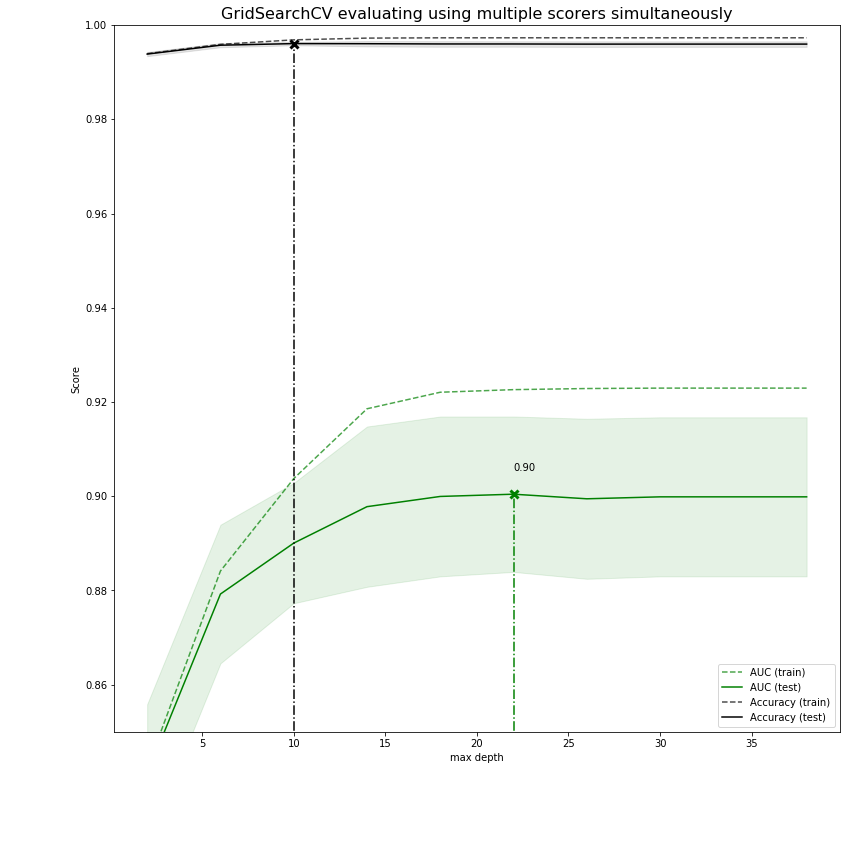

In [17]:
plot_score(gs.cv_results_)

In [18]:
print("AUC score: \t",gs.cv_results_['mean_test_AUC'].mean())
print("Accuracy score:\t",gs.cv_results_['mean_test_Accuracy'].mean())

AUC score: 	 0.8907596015191711
Accuracy score:	 0.9957604814989836


In [19]:
dt = gs.best_estimator_
dt

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=12, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=87,
            splitter='best')

In [20]:
X.shape

(594643, 31)

In [21]:
y_pred_fe_param_tune = cross_val_predict(dt, X, y, cv=cv, n_jobs=-1)

Confusion Matrix


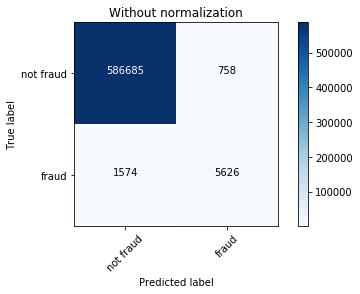

             precision    recall  f1-score   support

          0       1.00      1.00      1.00    587443
          1       0.88      0.78      0.83      7200

avg / total       1.00      1.00      1.00    594643

ROC_AUC score 0.8900492754663478


In [22]:
report(y,y_pred_fe_param_tune,class_names)

In [23]:
out = export_tree(dt,'dt_param_tune_fe')

results saved:  dt_param_tune_fe.pdf


In [24]:
PDF(out)

### Get Probabilities

In [25]:
y_pred_fe_param_tune_prob = cross_val_predict(dt, X, y, cv=cv, n_jobs=-1, method='predict_proba')
y_prob = [c[1] for c in y_pred_fe_param_tune_prob]

df_tmp = pd.concat([df, pd.DataFrame(y_pred_fe_param_tune, columns = ["prediction"]), pd.DataFrame(y_prob, columns = ["probability"])], axis=1)
df_tmp.head()

,step,customer,age,gender,merchant,category,amount,fraud,cust_tl_count_trans,cust_tl_mean_amount,...,cust_tl_std_amount,cust_tl_max_amount,cust_tl_min_amount,ol_cust_cat_amount,ol_cust_mer_amount,ol_cust_tl_amount,ol_cat_amount,ol_mer_amount,prediction,probability
0,0,1093826151,4,0,348934600,es_transportation,4.55,0,167.0,28.240719,...,18.035708,95.91,0.44,0.0,0.0,0.0,0.0,0.0,0,0.0
1,0,352968107,2,0,348934600,es_transportation,39.68,0,169.0,32.661361,...,23.194176,135.86,0.53,0.0,0.0,0.0,0.0,0.0,0,0.0
2,0,2054744914,4,1,1823072687,es_transportation,26.89,0,65.0,41.443692,...,35.455397,189.59,0.32,0.0,0.0,0.0,0.0,0.0,0,0.0
3,0,1760612790,3,0,348934600,es_transportation,17.25,0,171.0,30.338772,...,25.098264,162.48,0.07,0.0,0.0,0.0,0.0,0.0,0,0.0
4,0,757503768,5,0,348934600,es_transportation,35.72,0,145.0,31.696759,...,23.550817,168.45,0.01,0.0,0.0,0.0,0.0,0.0,0,0.0


### Load data in ElasticSearch

In [26]:
s = pd.to_datetime(pd.Series(['01/01/2010 15:00']*len(df_tmp)))
df_tmp["date"] = s + pd.to_timedelta(pd.np.ceil(df_tmp.step), unit="D")

In [30]:
df_tmp["date"] = pd.to_datetime(df_tmp["date"])
df_tmp.head(4)

,step,customer,age,gender,merchant,category,amount,fraud,cust_tl_count_trans,cust_tl_mean_amount,...,cust_tl_max_amount,cust_tl_min_amount,ol_cust_cat_amount,ol_cust_mer_amount,ol_cust_tl_amount,ol_cat_amount,ol_mer_amount,prediction,probability,date
0,0,1093826151,4,0,348934600,es_transportation,4.55,0,167.0,28.240719,...,95.91,0.44,0.0,0.0,0.0,0.0,0.0,0,0.0,2010-01-01 15:00:00
1,0,352968107,2,0,348934600,es_transportation,39.68,0,169.0,32.661361,...,135.86,0.53,0.0,0.0,0.0,0.0,0.0,0,0.0,2010-01-01 15:00:00
2,0,2054744914,4,1,1823072687,es_transportation,26.89,0,65.0,41.443692,...,189.59,0.32,0.0,0.0,0.0,0.0,0.0,0,0.0,2010-01-01 15:00:00
3,0,1760612790,3,0,348934600,es_transportation,17.25,0,171.0,30.338772,...,162.48,0.07,0.0,0.0,0.0,0.0,0.0,0,0.0,2010-01-01 15:00:00


In [33]:
df_tmp.dtypes

step                              int64
customer                          int64
age                               int64
gender                            int64
merchant                          int64
category                         object
amount                          float64
fraud                             int64
cust_tl_count_trans             float64
cust_tl_mean_amount             float64
cat_mean_amount                 float64
cust_mer_mean_amount            float64
cust_tl_median_amount           float64
cust_tl_std_amount              float64
cust_tl_max_amount              float64
cust_tl_min_amount              float64
ol_cust_cat_amount              float64
ol_cust_mer_amount              float64
ol_cust_tl_amount               float64
ol_cat_amount                   float64
ol_mer_amount                   float64
prediction                        int64
probability                     float64
date                     datetime64[ns]
dtype: object

In [37]:
import json
from elasticsearch import Elasticsearch

from elasticsearch import helpers
es = Elasticsearch()
list_rec = df_tmp.to_json(orient='records')
list_rec = json.loads(list_rec)

count=0
for rec in list_rec:
    count+=1
    try:
        res = es.index(index="test-index", doc_type='transaction', body=rec)
    except:
        continue


In [ ]:

#import h2o
#from h2o.estimators.deeplearning import H2ODeepLearningEstimator

#m = H2ODeepLearningEstimator()       
#m.train(X,y)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.callbacks import ModelCheckpoint, Callback
import numpy

class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

            
# Function to create model, required for KerasClassifier
def create_model(optimizer='rmsprop', init='glorot_uniform'):
	# create model
	model = Sequential()
	model.add(Dense(15, input_dim=len(X.columns.values), kernel_initializer=init, activation='relu'))
	model.add(Dense(1, kernel_initializer=init, activation='sigmoid'))
	# Compile model
	model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
	return model

seed = 7

model = KerasClassifier(build_fn=create_model, verbose=1)
#---------------------------------------------
#optimizers = ['rmsprop', 'adam']
#init = ['glorot_uniform', 'normal', 'uniform']
#epochs = [50, 100, 150]
kfold_weights_path='fw.h5'
callbacks = [
    EarlyStoppingByLossVal(monitor='val_loss', value=0.00001, verbose=1),
    # EarlyStopping(monitor='val_loss', patience=2, verbose=0),
    ModelCheckpoint(kfold_weights_path, monitor='val_loss', save_best_only=True, verbose=0),
]


history = model.fit(X[:-15000], y[:-15000], batch_size = 64, 
          epochs = 100, validation_split = 0.25, #callbacks=callbacks
                   )

print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
len(X[:-15000])

In [ ]:
X.tail()

In [ ]:
history.history['acc'][-10:]


In [ ]:
y_pred_dl = model.predict(X[-15000:])

In [ ]:
report(y[-15000:],y_pred_dl,class_names)